In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

class DataProcessor():
    
    def __init__(self, path):
        self.data_df = pd.read_csv(path)
        
    def eda(self, opt):
        # 搜索性 data 分析
        assert opt in ['view_data', 'missing_value', 'count_class_distri', 'text_length_distri', 'distribution_categorical_variables'], 'opt is wrong'
        if opt == 'view_data':
            # 查看 data 前幾行
            self._view_data()
        elif opt == 'missing_value':
            # 看缺失值
            self._missing_value()
        elif opt == 'count_class_distri':
            # 查看 class label 的分佈
            self._count_class_distri()
        elif opt == 'text_length_distri':
            # 查看 text 長度的分佈 
            self._text_length_distri()
        elif opt == 'distribution_categorical_variables':
            # 查看 text 長度的分佈 
            self._distribution_categorical_variables()
            
    def get_dataloader(self):
        # training
        data_list = self.data_df[['premise', 'hypothesis', 'label']].values.tolist()
        random.shuffle(data_list)
        k = len(data_list) // 5
        
        train_dataset = MyDataset(data_list[k:])
        train_dataloader = DataLoader(train_dataset, batch_size=8)
        dev_dataset = MyDataset(data_list[:k])
        dev_dataloader = DataLoader(dev_dataset, batch_size=16)
        
        return train_dataloader, dev_dataloader
    
    def _view_data(self):
        print(self.data_df.head())

    def _missing_value(self):
        print(self.data_df.isna().sum())
        
    def _count_class_distri(self):
        plt.figure(figsize=(6, 4))
        sns.countplot(data=self.data_df, x='label')
        plt.title('Class Distribution')
        plt.xlabel('class')
        plt.ylabel('count')
        plt.show
        
    def _text_length_distri(self):
        self.data_df['premise_length'] = self.data_df['premise'].apply(lambda x: len(x.split()))
        self.data_df['hypothesis_length'] = self.data_df['hypothesis'].apply(lambda x: len(x.split()))
        
        # 創一個帶有子圖的畫布
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # 在第一子圖中繪製 premise 的箱形圖
        sns.boxplot(data=self.data_df, y='premise_length', ax=axes[0])
        axes[0].set_title('premise_length distribution')
        axes[1].set_ylabel('length')
        
        # 在第二子圖中繪製 hypothesis 的箱形圖
        sns.boxplot(data=self.data_df, y='hypothesis_length', ax=axes[1])
        axes[1].set_title('hypothesis_length distribution')
        axes[1].set_ylabel('length')
        
        plt.tight_layout()
        plt.show
        
    def _distribution_categorical_variables(self):
        # 看每個語言的 label 分布
        sns.countplot(data=self.data_df, x='language', hue='label')
        plt.xticks(rotation=45)
        plt.show()

In [9]:
# 看一下 data 的樣子
processor = DataProcessor('train.csv')
processor.eda('view_data')

           id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv language  label  
0  The rules developed in the interim were put to...       en  English      0  
1  Practice groups are not permitted to work on t...       en  English      2  
2              J'essayais d'accomplir quelque chose.       fr   French      0  
3  They can't defend themselves because of their ...       en  English      0  
4    เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร       th     Thai      1  


In [20]:
# 看缺失
train_processor = DataProcessor('train.csv')
print("amount of missing values in train dataset:")
train_processor.eda('missing_value')

test_processor = DataProcessor('test.csv')
print("\namount of missing values in train dataset:")
test_processor.eda('missing_value')

amount of missing values in train dataset:
id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

amount of missing values in train dataset:
id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64


🥳🥳🥳 Nice! **沒有** missing value! 🥳🥳🥳

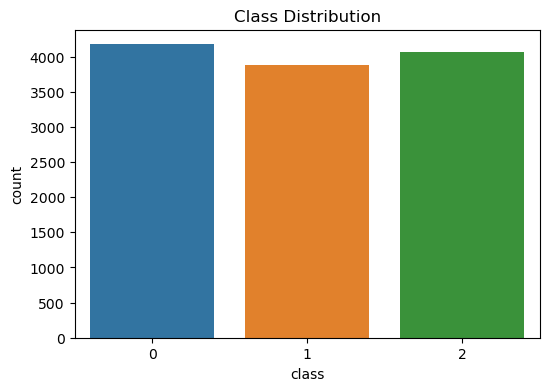

In [10]:
# 看 label 分佈
# 0 == entailment
# 1 == neutral
# 2 == contradiction
processor = DataProcessor('train.csv')
processor.eda('count_class_distri')

看起來分佈的**還行**...嗎? 至少我覺得蠻均勻的😳...

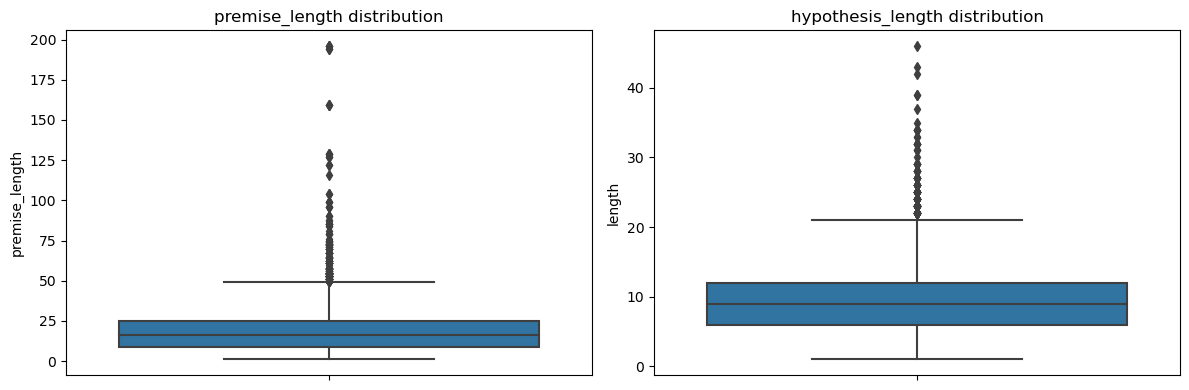

In [11]:
# 看 前提/假設 的箱型圖
processor = DataProcessor('train.csv')
processor.eda('text_length_distri')

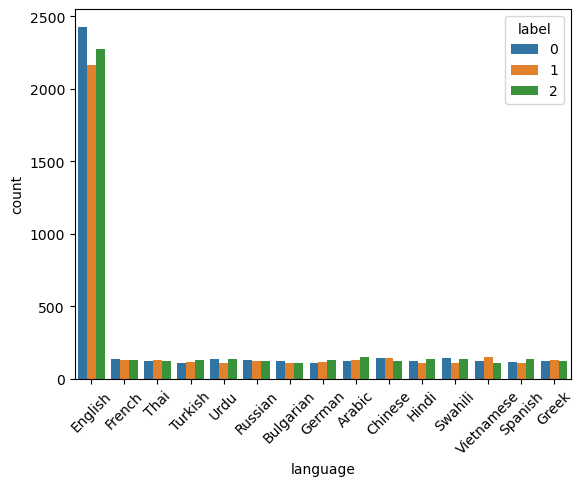

In [12]:
# 每個語言
processor = DataProcessor('train.csv')
processor.eda('distribution_categorical_variables')

In [13]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch

class MyDataset(Dataset):
    
    def __init__(self, data_list): # data_list = [['premise', 'hypothesis', 'label']], [], ..., []
        self.data = data_list
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        premise = self.data[idx][0]
        hypothesis = self.data[idx][1]
        label = self.data[idx][2]
        
        encoding = self.tokenizer(premise, hypothesis,
                                 add_special_tokens=True,
                                 max_length=128,
                                 padding='max_length',
                                 truncation=True,
                                 return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        label = torch.tensor(label, dtype=torch.long)
        
        return {'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': label}

In [14]:
processor = DataProcessor('train.csv')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_dataloader, dev_dataloader = processor.get_dataloader()
for batch in train_dataloader:
    print(batch['input_ids'].shape)
    print(batch['attention_mask'].shape)
    print(batch['label'].shape)
    print(tokenizer.batch_decode(batch['input_ids']))
    break

torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])
['[CLS] he reverted to his former point of view. [SEP] he went back to his previous thoughts about violence. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', '[CLS] the central features of the results act - strategic planning, performance measurement, and public reporting and accountability - can serve as powerful tools to help change the basic 